In [1]:
import json
import os
import pickle
import random
from collections import defaultdict

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
from openTSNE import TSNE
from scipy import stats
from tqdm.notebook import tqdm

In [2]:
project_dir = "C:\\Users\\tilenkopac\\Projects\\genome-embedding"
# project_dir = "/home/tkopac/personal/projects/genome-embedding"
# project_dir = "/d/hpc/home/tcurk/tkopac/genome-embedding"

dataset_dir = os.path.join(project_dir, "data", "deepmicrobes_mag_reads")

In [3]:
tax_rank = "genus"
with open(os.path.join(dataset_dir, "taxa_index.pkl"), "rb") as file:
    taxa_index = pickle.load(file)
with open(os.path.join(dataset_dir, "organism_taxa.pkl"), "rb") as file:
    organism_taxa = pickle.load(file)

In [4]:
n_embeddings = 0
with open(os.path.join(dataset_dir, "embeddings", "661k_conv_small_elu_loc_pres_ld10_ws100_take_2", "no-sampler", "val.csv"), "rt") as file:
    for _ in tqdm(file, desc="Counting embeddings"):
        n_embeddings += 1

Counting embeddings: 0it [00:00, ?it/s]

In [27]:
def density_estimation(m1, m2, xmin, xmax, ymin, ymax):
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([m1, m2])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    return X, Y, Z


def draw_contours(x, y, ax, color):
    # get mins and maxs for x and y
    xmin = np.min(x)
    xmax = np.max(x)
    ymin = np.min(y)
    ymax = np.max(y)

    # estimate density
    X, Y, Z = density_estimation(x, y, xmin, xmax, ymin, ymax)

    # draw density and contours
    # ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
    #           extent=[global_xmin, global_xmax, global_ymin, global_ymax])
    ax.contour(X, Y, Z, colors=color)
    ax.plot(x, y, marker='.', markersize=1, linestyle="None", color=color)

In [28]:
def analyse_autoencoder_embeddings(autoencoder_name, sampler_name, draw_latent_dist=True, draw_tsne=True):

    # read and sample embeddings and prepare taxonomic rank labels
    with open(os.path.join(dataset_dir, "embeddings", autoencoder_name, sampler_name, f"val.csv"), "rt") as file:
        labels, embeddings = [], []
        taxa_count = defaultdict(int)
        lines = file.readlines()
        for line in tqdm(lines, total=n_embeddings, desc="Reading embeddings"):
            org_id = line.strip().split(";")[0]
            taxon = organism_taxa[org_id][tax_rank]
            taxon_ind = taxa_index[tax_rank][taxon]
            # if taxa_count[taxon_ind] < 40000 and taxon_ind in {1, 4, 7, 11, 14, 17, 20, 23, 26, 29}:
            if taxa_count[taxon_ind] < 40000 and taxon_ind in {1, 7, 14, 20, 26}:

                # parse embedding
                embeddings.append(json.loads(line.strip().split(";")[1]))

                # prepare label
                org_id = line.strip().split(";")[0]
                taxon = organism_taxa[org_id][tax_rank]
                labels.append(taxa_index[tax_rank][taxon])

                # increment taxa count
                taxa_count[taxon_ind] += 1

    # shuffle embeddings and labels
    zipped = list(zip(embeddings, labels))
    random.shuffle(zipped)
    embeddings, labels = zip(*zipped)
    embeddings, labels = list(embeddings), list(labels)

    embeddings_np = np.array(embeddings)
    labels_np = np.array(labels)

    if draw_latent_dist:
        # draw latent value distributions
        n_cols = 5
        fig, axes = plt.subplots(int(np.ceil(embeddings_np.shape[1] / n_cols)), n_cols, figsize=(12, 6))
        fig.suptitle(autoencoder_name, fontsize=14)
        for i in range(embeddings_np.shape[1]):
            row = np.where(np.arange(0, embeddings_np.shape[1], n_cols) <= i)[0][-1]
            column = i % n_cols
            axes[row][column].hist(embeddings_np[:, i], bins=20)

    if draw_tsne:
        # calculate and draw t-sne
        print("Drawing t-SNE transformation")
        tsne = TSNE(perplexity=30, metric="euclidean", n_jobs=12, random_state=42, verbose=False)
        # todo: Preveri učinkovitost na 661k bacteria datasetu
        tsne_model = tsne.fit(embeddings_np[:int(0.75 * embeddings_np.shape[0])])
        tsne_embeddings = tsne_model.transform(embeddings_np[int(0.75 * embeddings_np.shape[0]):])
        tsne_labels = labels_np[-tsne_embeddings.shape[0]:]

        # fig, ax = plt.subplots()
        # ax.scatter(tsne_embedding_test[:, 0], tsne_embedding_test[:, 1], c=labels_np[int(0.5 * embeddings_np.shape[0]):])

        # draw density plots
        global_xmin = np.min(tsne_embeddings[:, 0])
        global_xmax = np.max(tsne_embeddings[:, 0])
        global_ymin = np.min(tsne_embeddings[:, 1])
        global_ymax = np.max(tsne_embeddings[:, 1])

        fix, ax = plt.subplots(figsize=(8, 8))
        ax.set_xlim([global_xmin, global_xmax])
        ax.set_ylim([global_ymin, global_ymax])

        for i, cls in enumerate(np.unique(tsne_labels)):
            embeddings_subset = tsne_embeddings[tsne_labels == cls, :]
            draw_contours(embeddings_subset[:, 0], embeddings_subset[:, 1], ax, list(mcolors.TABLEAU_COLORS)[i])

    return embeddings_np, labels_np
    # return embeddings_np, labels_np, tsne_embeddings, tsne_labels


# embeddings_np, labels_np = analyse_autoencoder_embeddings("661k_conv_small_elu_loc_pres_ld10_ws100_take_2",
#                                                           "no-sampler", draw_latent_dist=False,
#                                                           draw_tsne=True);

Reading embeddings:   0%|          | 0/5100000 [00:00<?, ?it/s]

Drawing t-SNE transformation


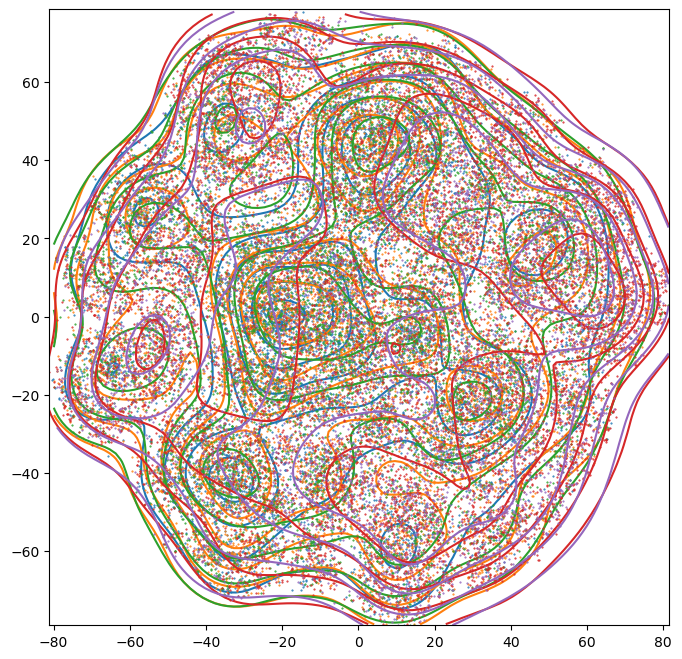

In [29]:
analyse_autoencoder_embeddings("661k_conv_small_elu_loc_pres_ld10_ws100_take_2", "no-sampler", draw_latent_dist=False,
                               draw_tsne=True);

Reading embeddings of "661k_conv_small_loc_pres_ld10_ws100" + "no-sampler":   0%|          | 0/5100000 [00:00<…

10 most common latent vectors:
	• [0.67, 0.6, 0.37, 0.38, 0.47, 0.88, 0.78, 0.36, 0.57, 0.73]: 6 (0.0001 %)
	• [0.35, 0.53, 0.68, 0.57, 0.51, 0.96, 0.79, 0.11, 0.64, 0.4]: 6 (0.0001 %)
	• [0.62, 0.48, 0.43, 0.46, 0.51, 0.92, 0.74, 0.64, 0.6, 0.22]: 6 (0.0001 %)
	• [0.36, 0.31, 0.69, 0.38, 0.47, 1.05, 0.91, 0.32, 0.44, 0.55]: 5 (0.0001 %)
	• [0.65, 0.38, 0.91, 0.34, 0.42, 0.98, 0.58, 0.45, 0.45, 0.19]: 5 (0.0001 %)
	• [0.8, 0.71, 0.5, 0.29, 0.68, 0.87, 0.59, 0.38, 0.45, 0.4]: 5 (0.0001 %)
	• [0.45, 0.35, 0.69, 0.37, 0.48, 0.82, 0.87, 0.43, 0.42, 0.74]: 5 (0.0001 %)
	• [0.5, 0.4, 0.62, 0.65, 0.29, 0.81, 0.73, 0.48, 0.6, 0.69]: 5 (0.0001 %)
	• [0.3, 0.69, 0.68, 0.54, 0.53, 1.0, 0.64, 0.2, 0.61, 0.59]: 5 (0.0001 %)
	• [0.61, 0.46, 0.69, 0.3, 0.64, 0.88, 0.66, 0.2, 0.72, 0.37]: 5 (0.0001 %)


Reading embeddings of "661k_conv_small_elu_loc_pres_ld10_ws100_take_2" + "no-sampler":   0%|          | 0/5100…

10 most common latent vectors:
	• [0.36, 0.01, 0.15, 0.29, 0.3, 0.36, 0.4, 0.32, 0.24, 0.45]: 7 (0.0001 %)
	• [0.29, 0.25, 0.42, 0.23, 0.19, 0.23, 0.39, 0.48, 0.3, 0.04]: 6 (0.0001 %)
	• [0.33, 0.16, 0.49, 0.36, 0.25, 0.34, 0.12, 0.39, 0.3, 0.34]: 6 (0.0001 %)
	• [0.37, 0.15, 0.31, 0.29, 0.16, 0.44, 0.23, 0.46, 0.29, 0.17]: 6 (0.0001 %)
	• [0.42, 0.3, 0.32, 0.04, 0.26, 0.57, 0.21, 0.2, 0.13, 0.21]: 6 (0.0001 %)
	• [0.36, 0.46, 0.28, 0.28, 0.15, 0.16, 0.41, 0.16, 0.04, 0.3]: 6 (0.0001 %)
	• [0.51, 0.34, 0.41, 0.26, 0.35, 0.08, 0.35, 0.38, 0.33, 0.38]: 5 (0.0001 %)
	• [0.32, 0.34, 0.31, 0.29, 0.37, 0.18, 0.23, 0.43, 0.27, 0.26]: 5 (0.0001 %)
	• [0.32, 0.5, 0.31, 0.33, 0.27, 0.39, 0.27, 0.22, 0.25, 0.19]: 5 (0.0001 %)
	• [0.18, 0.32, 0.4, 0.14, 0.17, 0.5, 0.13, 0.32, 0.25, 0.38]: 5 (0.0001 %)


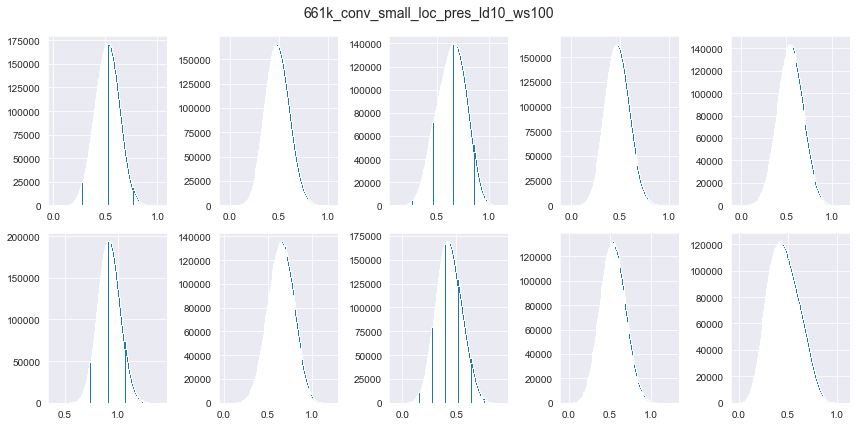

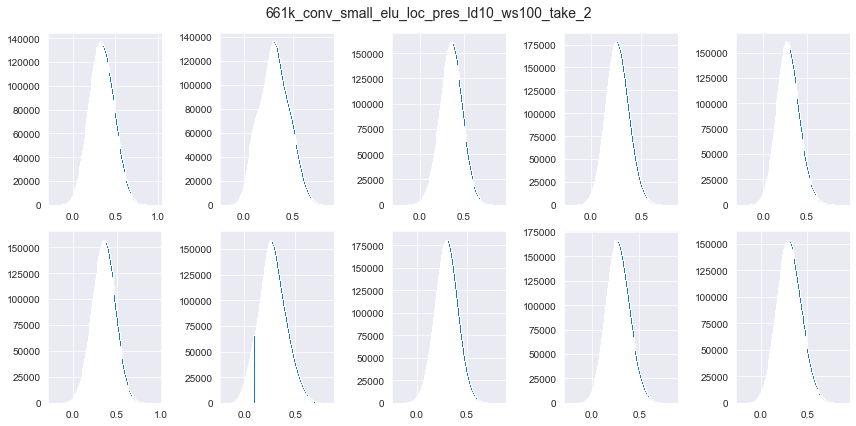

In [7]:
# autoencoder_names = [
#     "PARAMETER_TESTING_661k_conv_small_relu",
#     "PARAMETER_TESTING_661k_conv_small_relu_rec_only",
#     "PARAMETER_TESTING_661k_conv_small_elu",
#     "PARAMETER_TESTING_661k_conv_small_elu_rec_only",
#     "PARAMETER_TESTING_661k_conv_small_elu_argmax_activation",
#     "PARAMETER_TESTING_661k_conv_small_elu_rec_only_argmax_activation"
# ]
autoencoder_names = [
    "661k_conv_small_loc_pres_ld10_ws100",
    "661k_conv_small_elu_loc_pres_ld10_ws100_take_2"
]
for name in autoencoder_names:
    analyse_autoencoder_embeddings(name, "no-sampler")

In [ ]:
# todo: preslikaj vložitve v nižje dimenzionalni prostor (s t-SNE) in poglej, če se razredi med seboj vizualno ločijo - če ne, ima klasifikator zaradi tega verjetno težave – pošlji Tomažu, ko bo
# todo: če bo t-SNE dober, lahko poskusimo še rec only autoencoder